In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import env

# 1. Acquire data from mall_customers.customers in mysql database.

In [3]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [4]:
sql = '''
select *
from customers;
'''

In [5]:
df = pd.read_sql(sql, get_connection('mall_customers'))

df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
df = df.set_index("customer_id")

In [7]:
df.to_csv('mall_customers')

# 2. Summarize data (include distributions and descriptive statistics).

In [8]:
df.shape

(200, 4)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [10]:
df.dtypes

gender            object
age                int64
annual_income      int64
spending_score     int64
dtype: object

In [11]:
df.isnull().sum()

gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [12]:
df.describe()

,age,annual_income,spending_score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'annual_income'}>],
       [<AxesSubplot:title={'center':'spending_score'}>, <AxesSubplot:>]],
      dtype=object)

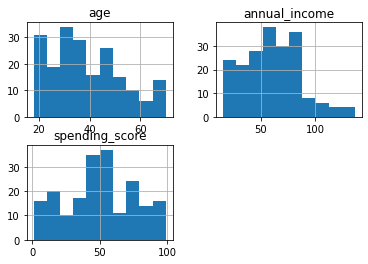

In [13]:
df.hist()

# 3. Detect outliers using IQR.

<AxesSubplot:xlabel='spending_score'>

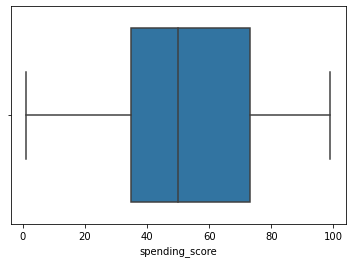

In [14]:
sns.boxplot(data = df, x = 'spending_score')

<AxesSubplot:xlabel='age'>

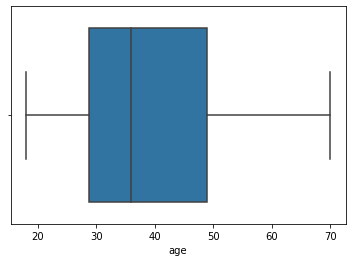

In [15]:
sns.boxplot(data = df, x = 'age')

<AxesSubplot:xlabel='annual_income'>

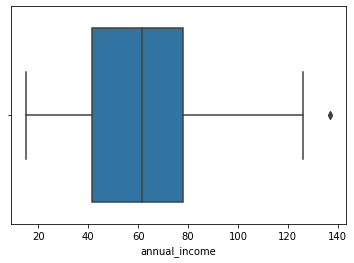

In [16]:
sns.boxplot(data = df, x = 'annual_income')

In [17]:
## there do not appear to be many outliers 

In [18]:
q1, q3 = df.annual_income.quantile([.25, .75])

iqr = q3 - q1

upperbound = q3 + 3.0 * iqr
lowerbound = q1 - 3.0 * iqr


In [19]:
upperbound

187.5

In [20]:
lowerbound

-68.0

In [21]:
q1, q3 = df.spending_score.quantile([.25, .75])

iqr = q3 - q1

upperbound = q3 + 3.0 * iqr
lowerbound = q1 - 3.0 * iqr

In [22]:
upperbound

187.75

In [23]:
lowerbound

-80.0

In [24]:
q1, q3 = df.age.quantile([.25, .75])

iqr = q3 - q1

upperbound = q3 + 3.0 * iqr
lowerbound = q1 - 3.0 * iqr

In [25]:
upperbound

109.75

In [26]:
lowerbound

-32.0

# 4. Split data (train, validate, and test split).

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
def split(df, stratify_by=None):
    """
    Crude train, validate, test split
    To stratify, send in a column name
    """
    
    if stratify_by == None:
        train, test = train_test_split(df, test_size=.2, random_state=319)
        train, validate = train_test_split(train, test_size=.3, random_state=319)
    else:
        train, test = train_test_split(df, test_size=.2, random_state=319, stratify=df[stratify_by])
        train, validate = train_test_split(train, test_size=.3, random_state=319, stratify=train[stratify_by])
    
    return train, validate, test

In [29]:
df.shape

(200, 4)

In [30]:
train, validate, test = split(df)

In [31]:
train.head()

,gender,age,annual_income,spending_score
customer_id,,,,
61,Male,70,46,56
160,Female,30,78,73
96,Male,24,60,52
2,Male,21,15,81
17,Female,35,21,35


In [32]:
train.shape

(112, 4)

In [33]:
validate.shape

(48, 4)

In [34]:
test.shape

(40, 4)

# 5. Encode categorical columns using a one hot encoder (pd.get_dummies).

In [35]:
dummy_df = pd.get_dummies(df[['gender']], dummy_na=False, drop_first=[True])

In [36]:
dummy_df

,gender_Male
customer_id,
1,1
2,1
3,0
4,0
5,0
...,...
196,0
197,0
198,1


In [37]:
dummy_df = dummy_df.rename(columns = {'gender_Male' : 'male'})    


In [38]:
df = pd.concat([df, dummy_df], axis=1)

In [39]:
df = df.drop(columns = 'gender')

df.head()

,age,annual_income,spending_score,male
customer_id,,,,
1,19,15,39,1
2,21,15,81,1
3,20,16,6,0
4,23,16,77,0
5,31,17,40,0


# 6. Handles missing values.

In [40]:
df.isnull().sum()

age               0
annual_income     0
spending_score    0
male              0
dtype: int64

In [41]:
# no missing values

# 7. Scaling

In [44]:
import sklearn

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
scaler = sklearn.preprocessing.MinMaxScaler()

In [46]:
scaler.fit(df)

MinMaxScaler()

In [49]:
df_scaled = scaler.transform(df)



In [50]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

df_scaled.head()

,age,annual_income,spending_score,male
0,0.019231,0.000000,0.387755,1.0
1,0.057692,0.000000,0.816327,1.0
2,0.038462,0.008197,0.051020,0.0
3,0.096154,0.008197,0.775510,0.0
4,0.250000,0.016393,0.397959,0.0
